In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()


In [3]:
oddsratio_cutoff = 1.8
lgp_cutoff = 20

## Get Layer Specific Markers

In [4]:
layer_23_markers = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMGAnalysis/region_hypo_genes.IT-L23.obj'
)
layer_5_markers = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMGAnalysis/region_hypo_genes.IT-L5.obj'
)
layer_6_markers = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMGAnalysis/region_hypo_genes.IT-L6.obj'
)

## DMR Counts

In [5]:
dmr_dir = '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMRAnalysis/RegionSpecificDMR/'
dmr_list = list(pathlib.Path(dmr_dir).glob('**/*DMS1.bed'))
dmr_counts = {p.name.split('.')[0]: pd.read_csv(p, sep='\t').shape[0] for p in dmr_list}

dmr_counts = pd.Series(dmr_counts).reset_index()
dmr_counts.columns = ['Group', '# DMR']
dmr_counts['Layer'] = dmr_counts['Group'].apply(lambda i: i.split('+')[0])
dmr_counts['Region'] = dmr_counts['Group'].apply(lambda i: i.split('+')[1])
dmr_counts

,Group,# DMR,Layer,Region
0,IT-L4+MOs,32757,IT-L4,MOs
1,IT-L4+MOp,36899,IT-L4,MOp
2,IT-L4+SSp,42781,IT-L4,SSp
3,IT-L4+SSs,21319,IT-L4,SSs
4,IT-L5+SSp,41503,IT-L5,SSp
5,IT-L5+PFC,86125,IT-L5,PFC
6,IT-L5+AI,36572,IT-L5,AI
7,IT-L5+MOs,13726,IT-L5,MOs
8,IT-L5+MOp,9277,IT-L5,MOp
9,IT-L5+ORB,16943,IT-L5,ORB


## Gene and motif metadata

In [6]:
motif_meta_with_cluster = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv',
    index_col='motif_uid'
)

In [7]:
gene_meta = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
                        sep='\t', index_col='gene_id')

In [8]:
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
tf_class.head()

,uid,GeneRawName,SuperClass,Class,Family,SubFamily,EnsemblID
0,1.1.1.1.1,c-Jun,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000052684
1,1.1.1.1.2,JunB,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,"ENSMUSG00000052837,ENSMUSG00000052926"
2,1.1.1.1.3,JunD,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000071076
3,1.1.1.2.1,NFE2,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000058794
4,1.1.1.2.2,NFE2L1,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000038615


In [9]:
level = 'Family'
gene_to_tf_class = {}
for _, row in tf_class.iterrows():
    if isinstance(row['EnsemblID'], float):
        continue
    for g in row['EnsemblID'].split(','):
        gene_to_tf_class[g] = row[level]
motif_meta_with_cluster['motif_class'] = motif_meta_with_cluster['gene_ids'].map(
    lambda i: gene_to_tf_class[i.split('.')[0]] if i.split('.')[0] in gene_to_tf_class else '')

level = 'SubFamily'
gene_to_tf_class = {}
for _, row in tf_class.iterrows():
    if isinstance(row['EnsemblID'], float):
        continue
    for g in row['EnsemblID'].split(','):
        gene_to_tf_class[g] = row[level]
motif_meta_with_cluster['motif_class_sub'] = motif_meta_with_cluster['gene_ids'].map(
    lambda i: gene_to_tf_class[i.split('.')[0]] if i.split('.')[0] in gene_to_tf_class else '')

## Motif Results

In [10]:
motif_results = list(pathlib.Path().glob('IT-L*/MotifEnrichment/*.motif_enrichment.msg'))
motif_results = pd.concat([pd.read_msgpack(path) for path in motif_results])
motif_results.index.name = 'MotifID'
motif_results.reset_index(inplace=True)
motif_results = pd.concat([motif_results, 
           motif_meta_with_cluster.loc[motif_results['MotifID']].reset_index(drop=True)], axis=1)

filtered_results = motif_results[(motif_results['oddsratio'] > oddsratio_cutoff) & 
                              (motif_results['-lgp'] > lgp_cutoff)].copy()


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  


In [11]:
# for each motif class in each group, select most significant ones
use_motif_for_clase_group = motif_results.groupby(['motif_class', 'Group']).apply(
    lambda i: i.sort_values('-lgp', ascending=False)['MotifID'].iloc[0])

In [12]:
# keep one motif for each group and each motif class
use_results = motif_results.set_index(['Group', 'MotifID']).loc[[
    tuple(row.tolist())
    for _, row in use_motif_for_clase_group.reset_index().iloc[:, 1:].iterrows()
]].reset_index()
use_results = use_results[use_results['motif_class'].fillna('') != ''].copy()

assert (use_results.groupby(['motif_class', 'Group']).apply(lambda i: i.shape[0]) != 1).sum() == 0

In [13]:
# only keep motif class that has sig hits
sig_motif_class = filtered_results['motif_class'].unique()
use_results = use_results[use_results['motif_class'].isin(sig_motif_class)].copy()

In [14]:
motif_class_order = [
    'B-ATF-related',
    'Fos-related',
    'PD+HD',
    'HD-LIM',
    'HOX',
    'NK',
    'Paired-related HD',
    'POU',
    # 'Thyroid hormone receptor-related factors',
    # 'CEBP-related',
    # 'More than 3 adjacent zinc fingers',
    'MyoD-ASC-related',
    'DMRT',
    # 'Regulators of differentiation',
    'RFX',
    'Tal-related',
    'bHLH-ZIP',
][::-1]

layer_order = [
    'IT-L23+ORB',
    'IT-L23+PFC',
    'IT-L23+ACA',
    'IT-L23+AI',
    'IT-L23+MOs',
    'IT-L23+MOp',
    'IT-L23+SSp',
    'IT-L23+SSs',
]

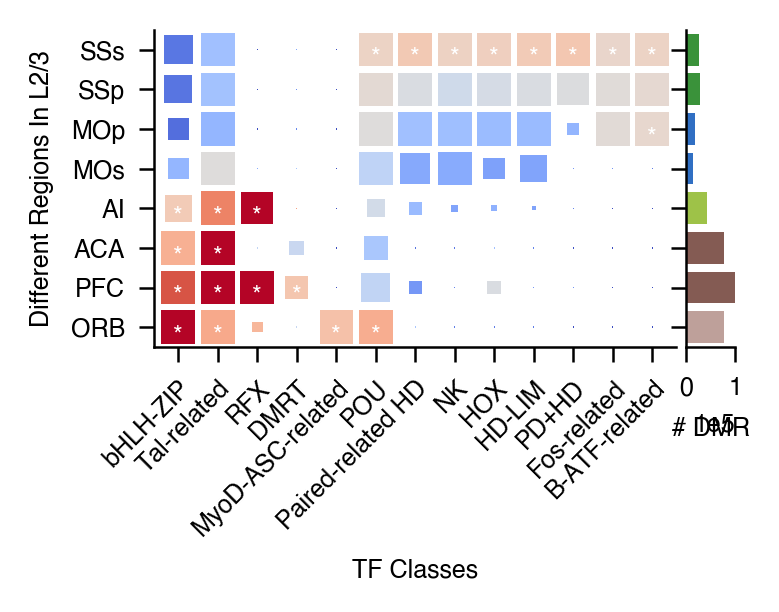

In [21]:
use_results = use_results[use_results['motif_class'].isin(motif_class_order) & 
                          use_results['Group'].isin(layer_order)]
use_results['x'] = use_results['motif_class'].apply(lambda i: motif_class_order.index(i))
use_results['y'] = use_results['Group'].apply(lambda i: layer_order.index(i))
pass_filter_pairs = filtered_results.set_index(['MotifID', 'Group']).index
use_results['sig'] = use_results.apply(lambda i: (i['MotifID'], i['Group']) in pass_filter_pairs, axis=1)

fig = plt.figure(figsize=(2.5, 1.4), dpi=300)
gs = fig.add_gridspec(1, 10)
ax_main = fig.add_subplot(gs[:, :-1])
ax_bar = fig.add_subplot(gs[:, -1:])

ax = ax_main
sns.scatterplot(ax=ax, data=use_results, x='x', y='y', 
                hue='oddsratio', hue_norm=(1, 2.5), palette='coolwarm', marker='s',
                size='-lgp', size_norm=(10, 50), sizes=(0.1, 65), linewidth=0, clip_on=False)

for _, row in use_results[use_results['sig']].iterrows():
    ax.text(row['x'], row['y']-0.23, '*', ha='center', va='center', fontsize=labelsize, c='white')

ax.set(xticks=range(len(motif_class_order)), 
       ylim=(-0.5, len(layer_order)-0.5), yticklabels=[i.split('+')[1] for i in layer_order], yticks=list(range(len(layer_order))),
       xticklabels=[i[:20] for i in motif_class_order], xlabel='TF Classes', ylabel='Different Regions In L2/3')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
sns.despine(ax=ax)
ax.legend_.set_visible(False)

ax = ax_bar
group_palette = {g: sub_region_palette[g.split('+')[1]] for g in layer_order}
sns.barplot(ax=ax, data=dmr_counts, x='# DMR', y='Group', palette=group_palette,
            order=layer_order[::-1])
ax.set(xlim=(0, 100000), yticklabels=[], xticks=[0, 100000], ylabel='')
ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
sns.despine(ax=ax)

fig.savefig(f'RegionSpecificDMR.IT-L23.heatmap.pdf', bbox_inches='tight')